In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

# from dask.distributed import Client
# from dask_kubernetes import KubeCluster

# cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=20, interval='2s')
# client = Client(cluster)
# client

In [3]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [4]:
var_name = 'tas'
df_var = df[(df.table_id == 'Amon') & (df.variable_id == var_name)
                & ((df.experiment_id == 'piControl') | (df.experiment_id == 'historical') | (df.experiment_id == '1pctCO2'))]
len(df_var)

279

In [5]:
run_counts = df_var.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id        experiment_id
BCC-CSM2-MR      1pctCO2           1
                 historical        3
                 piControl         1
BCC-ESM1         1pctCO2           1
                 historical        3
                 piControl         1
CAMS-CSM1-0      1pctCO2           2
                 historical        2
                 piControl         1
CESM2            1pctCO2           1
                 historical       11
                 piControl         1
CESM2-WACCM      1pctCO2           1
                 historical        3
                 piControl         1
CNRM-CM6-1       1pctCO2           1
                 historical       13
                 piControl         1
CNRM-ESM2-1      1pctCO2           4
                 historical        5
                 piControl         1
CanESM5          1pctCO2           6
                 historical       50
                 piControl         2
E3SM-1-0         1pctCO2           1
                 historical        5
       

In [7]:
source_ids = []
experiment_ids = ['historical', 'piControl', '1pctCO2']
for name, group in df_var.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'NESM3',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [8]:
def load_tas_data(source_id, expt_id):
    """
    Load monthly atmospheric near-surface air temperature data for given source and expt ids
    """
    uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 2.)),
                     'lon': (['lon'], np.arange(0.5, 360., 2.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [9]:
source_id = source_ids[0]
ds = load_tas_data(source_id, 'historical').sel(time=slice('1980', '2019')).mean(dim='time')

In [10]:
results = {}

first = 1
for source_id in tqdm(source_ids):
    # take 1980-2019 mean
    ds = (load_tas_data(source_id, 'historical')
          .sel(time=slice('1980', '2019'))
          .mean(dim='time'))
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(ds[var_name], ds_out)
    ds_new.attrs['name'] = source_id
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
    # Add run to ensemble DataArray
    if first:
        ens = ds_new
        first = 0
    else:
        ens = xr.concat([ens, ds_new], pd.Index(np.append(ens.ensemble.values, ds_new.attrs['name']), name='ensemble'))

Create weight file: bilinear_160x320_89x180_peri.nc
Create weight file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Create weight file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Create weight file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Create weight file: bilinear_180x360_89x180_peri.nc
Create weight file: bilinear_256x512_89x180_peri.nc
Create weight file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Create weight file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Create weight file: bilinear_144x192_89x180_peri.nc
Create weight file: bilinear_143x144_89x180_peri.nc
Create weight file: bilinear_80x96_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse exist

In [11]:
# Use multi-model mean as temporary stand-in for observations
obs = ens.mean(dim='ensemble').compute()

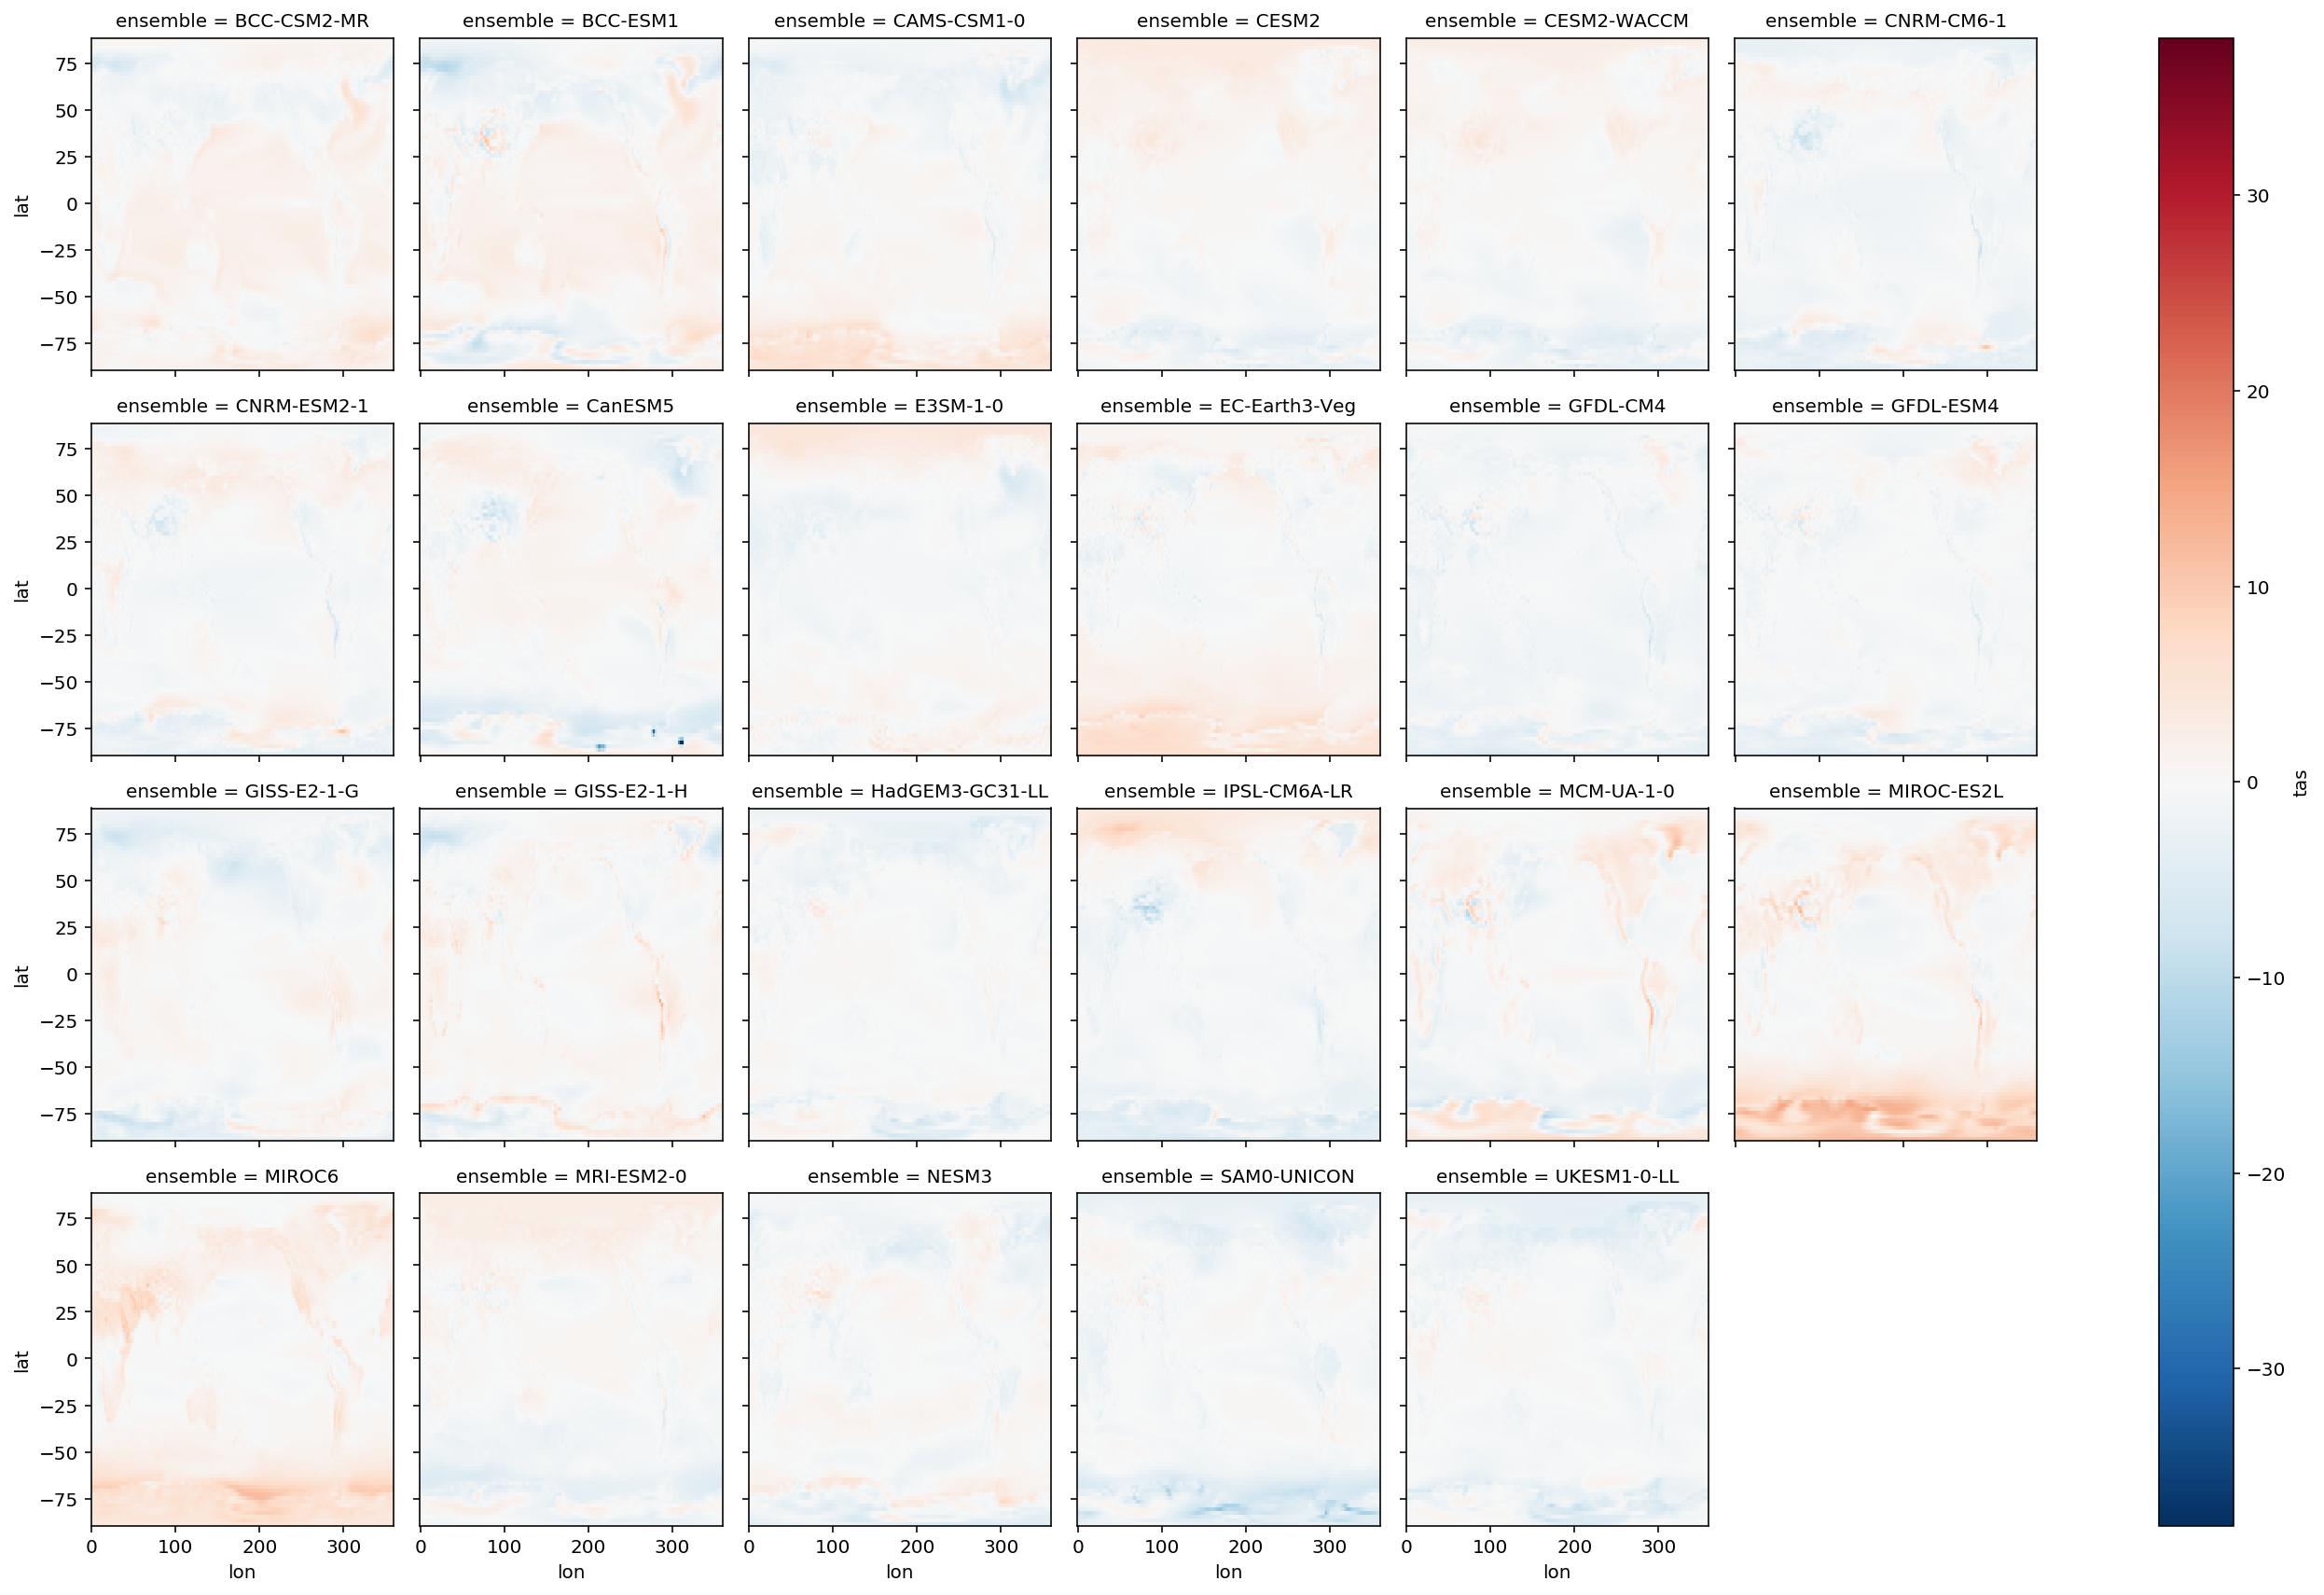

In [52]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q = (ens-obs).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
# How to change color bar limits?

In [12]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens.attrs['rmse'] = {}
ens.attrs['mae'] = {}
for ensemble in ens.ensemble:
    ds = ens.sel(ensemble=ensemble)
    ens.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs, ds, ['lat', 'lon']).values
    ens.attrs['mae'][str(ensemble.values)] = xs.mae(obs, ds, ['lat', 'lon']).values
ens.attrs

{'regrid_method': 'bilinear',
 'rmse': {'BCC-CSM2-MR': array(1.65575384),
  'BCC-ESM1': array(2.20923598),
  'CAMS-CSM1-0': array(2.03660009),
  'CESM2': array(1.58787975),
  'CESM2-WACCM': array(1.44785836),
  'CNRM-CM6-1': array(1.67564631),
  'CNRM-ESM2-1': array(1.45252437),
  'CanESM5': array(1.99439207),
  'E3SM-1-0': array(1.59582343),
  'EC-Earth3-Veg': array(2.19161442),
  'GFDL-CM4': array(1.5420321),
  'GFDL-ESM4': array(1.31109796),
  'GISS-E2-1-G': array(1.77539169),
  'GISS-E2-1-H': array(1.58641873),
  'HadGEM3-GC31-LL': array(1.352652),
  'IPSL-CM6A-LR': array(2.16020421),
  'MCM-UA-1-0': array(2.1572245),
  'MIROC-ES2L': array(3.92565732),
  'MIROC6': array(3.04092872),
  'MRI-ESM2-0': array(1.65096503),
  'NESM3': array(1.42512507),
  'SAM0-UNICON': array(2.44762042),
  'UKESM1-0-LL': array(1.80119218)},
 'mae': {'BCC-CSM2-MR': array(1.34470804),
  'BCC-ESM1': array(1.75486936),
  'CAMS-CSM1-0': array(1.43192034),
  'CESM2': array(1.22127247),
  'CESM2-WACCM': array(1

(0, 4.25)

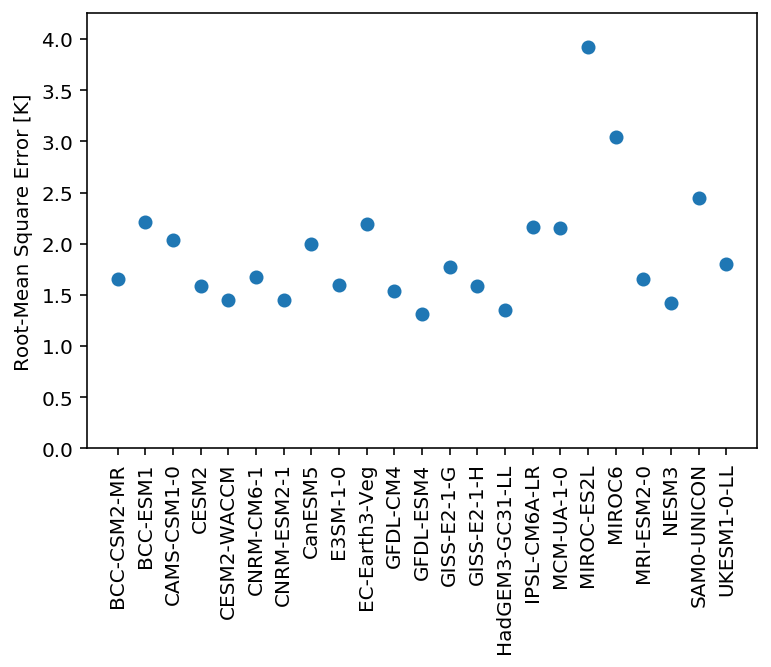

In [13]:
plt.plot(list(ens.attrs['rmse'].values()),'C0o')
plt.xticks(np.arange(len(ens.attrs['rmse'].keys())),list(ens.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Root-Mean Square Error [K]')
plt.ylim([0,4.25])

23